In [6]:
# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [2]:
# Load dataset
data = pd.read_csv('../data/processed/top_150_fantasy_reviews_balanced_capped_cleaned.csv')
texts = data['review']
labels = data['recommendation'].map({'Recommended': 2, 'Mixed Feelings': 1, 'Not Recommended': 0})

# Tokenizer
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_data(data, tokenizer):
    return tokenizer(data.tolist(), padding=True, truncation=True)

/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Tokenize
train_encodings = tokenize_data(train_texts, tokenizer)
val_encodings = tokenize_data(val_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

# Custom Dataset Wrapper
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Wrap datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)


In [9]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=3,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    # eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    fp16=False,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[],
    logging_strategy='no',
    no_cuda=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train
trainer.train()

/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/transformers/training_args.py:1453: FutureWarning: usin

Step,Training Loss


TrainOutput(global_step=447, training_loss=0.5370434583966898, metrics={'train_runtime': 10634.7128, 'train_samples_per_second': 0.673, 'train_steps_per_second': 0.042, 'total_flos': 1880208483084288.0, 'train_loss': 0.5370434583966898, 'epoch': 2.9949748743718594})

In [11]:
# Evaluate the model
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Reattach compute_metrics (doesn't retrain, just sets up evaluation)
trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # optional here
    eval_dataset=val_dataset,      # optional here
    compute_metrics=compute_metrics
)

# Evaluate on test set
metrics = trainer2.evaluate(eval_dataset=test_dataset, metric_key_prefix='test')

# Print metrics
for key in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    print(f"{key}: {metrics[key]:.4f}")


{'test_loss': 0.7478624582290649,
 'test_runtime': 155.0829,
 'test_samples_per_second': 3.301,
 'test_steps_per_second': 0.825,
 'epoch': 2.9949748743718594}

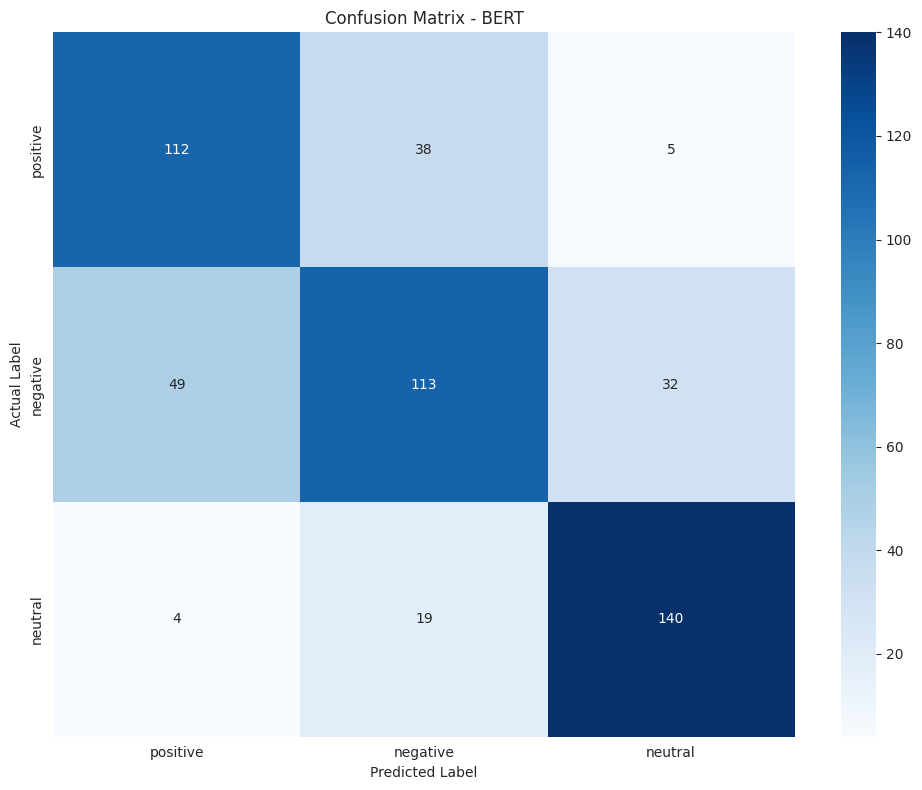

In [20]:
import seaborn as sns

labels = ['positive', 'negative', 'neutral']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()


In [24]:
num_test = len(test_dataset)
df_test = data.iloc[-num_test:].copy()
df_test['bert_label'] = bert_preds

In [25]:
def map_recommendation(rec):
    if rec == 'Recommended':
        return 'positive'
    elif rec == 'Not Recommended':
        return 'negative'
    else:
        return 'neutral'

df_test['recommendation_mapped'] = df_test['recommendation'].apply(map_recommendation)

In [30]:
# Inverse map for predictions
label_map_inv = {2: 'positive', 0: 'negative', 1: 'neutral'}

# Create evaluation DataFrame from the test split
df_eval = pd.DataFrame({
    'review': test_texts.values,
    'true_label': test_labels.map(label_map_inv).values,
    'predicted_label': [label_map_inv[i] for i in preds.predictions.argmax(-1)]
})

# Classification report
from sklearn.metrics import classification_report

print("=== BERT Evaluation (aligned with trainer test split) ===")
print(classification_report(df_eval['true_label'], df_eval['predicted_label'], digits=3))


=== BERT Evaluation (aligned with trainer test split) ===
              precision    recall  f1-score   support

    negative      0.679     0.723     0.700       155
     neutral      0.665     0.582     0.621       194
    positive      0.791     0.859     0.824       163

    accuracy                          0.713       512
   macro avg      0.711     0.721     0.715       512
weighted avg      0.709     0.713     0.709       512



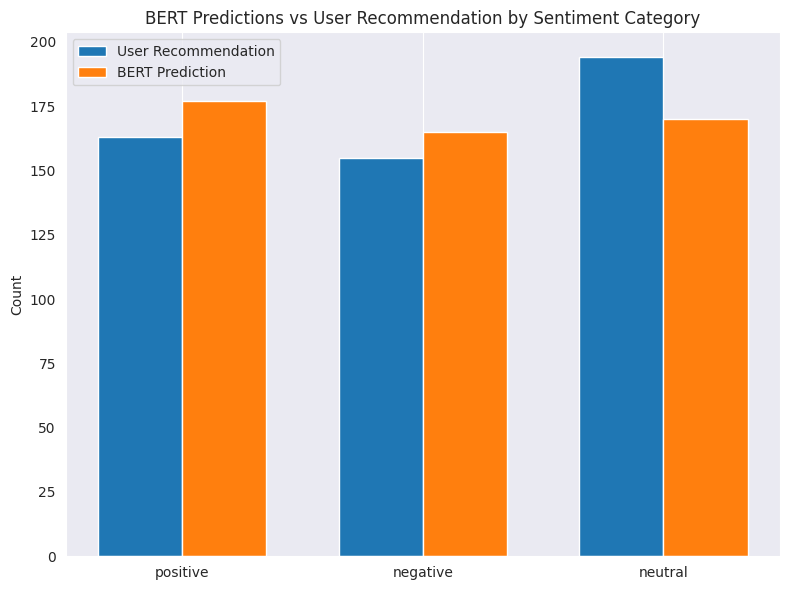

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define sentiment categories in desired order
categories = ['positive', 'negative', 'neutral']

# Count user-mapped recommendations
recommendation_counts = [df_test[df_test['recommendation_mapped'] == cat].shape[0] for cat in categories]

# Count BERT predictions
bert_counts = [df_test[df_test['bert_label'] == cat].shape[0] for cat in categories]

# Bar plot parameters
x = np.arange(len(categories))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, recommendation_counts, width, label='User Recommendation')
bars2 = ax.bar(x + width/2, bert_counts, width, label='BERT Prediction')

# Formatting
ax.set_ylabel('Count')
ax.set_title('BERT Predictions vs User Recommendation by Sentiment Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()
